In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import DenseLayer
from lasagne.layers import Upscale1DLayer, TransposedConv2DLayer, BiasLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv2DLayer
from lasagne.layers import InputLayer, ExpressionLayer
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=300000_S=200_M=20_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7ff6739f0790>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff661030310>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff661011f10>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7ff6739e6290>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7ff661030fd0>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7ff6739f0d90>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff660fc02d0>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff660fc0150>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7ff6739ff950>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7ff660fc0810>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7ff660fc0850>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7ff660fc0e90>,
 'dense1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7ff660fc0cd0>,
 'dense1_bias': <lasagne.layers.special.Bias

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.13008 -- accuracy=95.44%  
  valid loss:		0.04924
  valid accuracy:	0.98478+/-0.00935
  valid auc-roc:	0.98760+/-0.01981
  valid auc-pr:		0.87319+/-0.19021
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.03739 -- accuracy=98.84%  
  valid loss:		0.02822
  valid accuracy:	0.99106+/-0.00628
  valid auc-roc:	0.99494+/-0.00866
  valid auc-pr:		0.93439+/-0.12149
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.02431 -- accuracy=99.22%  
  valid loss:		0.02082
  valid accuracy:	0.99313+/-0.00515
  valid auc-roc:	0.99684+/-0.00492
  valid auc-pr:		0.95541+/-0.08050
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000

In [5]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 20, 200, 1)
parameters: W
layer3: 
shape:(None, 20, 200, 1)
parameters: b
layer4: 
shape:(None, 20, 200, 1)
parameters: beta, gamma, mean, inv_std
layer5: 
shape:(None, 20, 200, 1)
layer6: 
shape:(None, 20, 50, 1)
layer7: 
shape:(None, 40, 50, 1)
parameters: W
layer8: 
shape:(None, 40, 50, 1)
parameters: b
layer9: 
shape:(None, 40, 50, 1)
parameters: beta, gamma, mean, inv_std
layer10: 
shape:(None, 40, 50, 1)
layer11: 
shape:(None, 40, 25, 1)
layer12: 
shape:(None, 200)
parameters: W
layer13: 
shape:(None, 200)
parameters: b
layer14: 
shape:(None, 200)
parameters: beta, gamma, mean, inv_std
layer15: 
shape:(None, 200)
layer16: 
shape:(None, 20)
parameters: W
layer17: 
shape:(None, 20)
parameters: b
layer18: 
shape:(None, 20)
---------------------------------

In [6]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                correction = 3/2
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)



def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt

def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype('float32'), y[excerpt].astype('int32')


def get_feature_map_all(layer, input_var, X, batch_size=500):
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        fmaps[index] = feature_maps(X[index])
    return fmaps

def get_feature_map(layer, input_var, X, index):
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    
    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    return feature_maps(X[index])

def pseudoinverse_filter2(W1):
    #W1 = W1.transpose([2,0,1,3])
    weight = np.squeeze(W1)    
    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


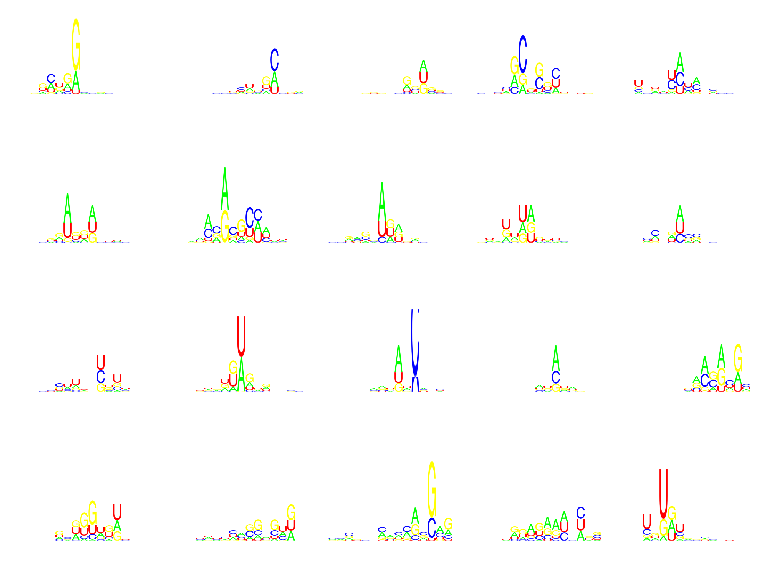

In [7]:
# plot convolutional filter --> sequence logo
W = get_weights(network['conv1'], convert_pwm=1)

num_filters = W.shape[0]
nrows = np.ceil(np.sqrt(num_filters)).astype(int)
ncols = nrows
height=300
bp_width=30
adjust=-1.5,
size = (100.0, 100.0)
fig = plt.figure(figsize=size)
fig.set_size_inches(size[0],size[1], forward=True);
grid= mpl.gridspec.GridSpec(nrows, ncols)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)     
for i in range(num_filters):
    plt.subplot(grid[i])

    MIN = np.min(W[i])
    MAX = np.max(W[i])
    pwm = (W[i] - MIN)/(MAX-MIN)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    num_seq = pwm.shape[1]
    width = bp_width*num_seq
    logo = seq_logo(pwm, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    plt.axis('off')
    

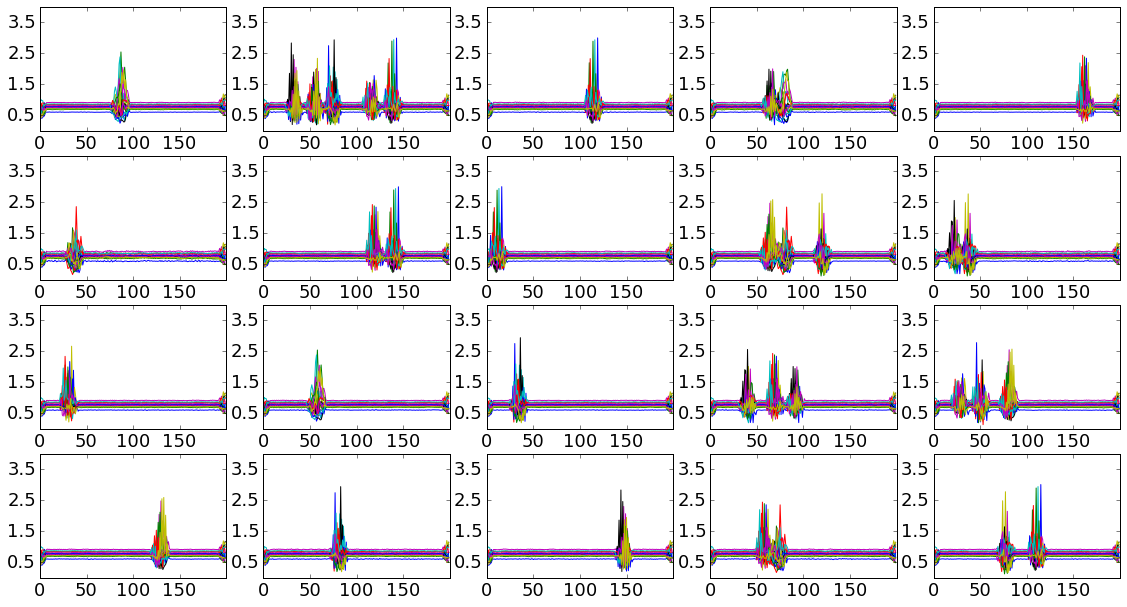

In [8]:
def get_class_activation(fmaps, y, batch_size=512):
    fmaps = np.squeeze(fmaps)
    mean_activation = []
    std_activation = []
    for i in range(y.shape[1]):
        index = np.where(y[:,i] == 1)[0]
        mean_activation.append(np.nanmean(fmaps[index], axis=0))
        std_activation.append(np.nanstd(fmaps[index], axis=0))
    return np.array(mean_activation), np.array(std_activation)


def plot_mean_activations(mean_activation, options):
    num_labels = len(mean_activation)
    nrows = np.ceil(np.sqrt(num_labels)).astype(int)
    ncols = nrows

    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_labels):
        plt.subplot(grid[i])
        plt.plot(mean_activation[i].T)
        fig_options(plt, options)
    return plt


fmaps = get_feature_map_all(network['conv1_active'], nnmodel.input_var, train[0])
mean_activation, std_activation = get_class_activation(fmaps, train[1])
options = { 'ylim': [0, 4],
            'xticks': [0, 50, 100, 150],
            'yticks': [0.5, 1.5, 2.5, 3.5],
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)

In [9]:
map_index = range(10000)
fmaps2 = get_feature_map(network['conv2_active'], nnmodel.input_var, train[0], map_index)
pool = get_feature_map(network['conv2_pool'], nnmodel.input_var, train[0], map_index)

In [10]:
pool_size = 2
fmap2 = []
for k in range(fmaps2.shape[0]):
    x = np.squeeze(fmaps2[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)

0.5


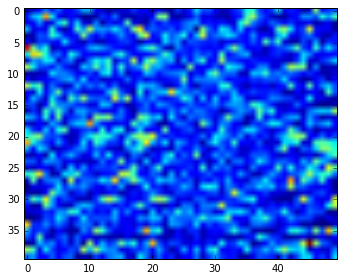

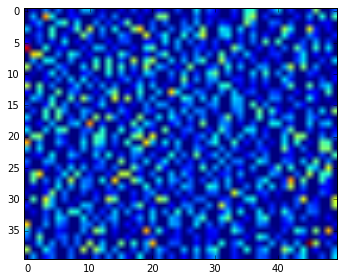

In [11]:
plt.figure()
plt.imshow(np.squeeze(fmaps2[1]))
plt.figure()
plt.imshow(np.squeeze(fmap2[1]))

print float(np.sum(fmaps2 == fmap2)) / np.prod(list(fmaps2.shape))

In [63]:
active = theano.function([nnmodel.input_var], layers.get_output(network['conv1_active']), allow_input_downcast=True)
bias = theano.function([nnmodel.input_var], layers.get_output(network['conv1_bias']), allow_input_downcast=True)
conv = theano.function([nnmodel.input_var], layers.get_output(network['conv1']), allow_input_downcast=True)

X = train[0][map_index]
a = np.squeeze(active(X))
b = np.squeeze(bias(X))
c = np.squeeze(conv(X))

In [41]:
beta = network['conv1_batch'].beta.get_value()
gamma = network['conv1_batch'].gamma.get_value()
mean = network['conv1_batch'].mean.get_value()
inv_std = network['conv1_batch'].inv_std.get_value()

# y = (x - mean) * (gamma * inv_std) + beta
# X = (y - beta)/(gamma*inv_std) + mean

beta = np.outer(beta,np.ones(200))
gamma = np.outer(gamma,np.ones(200))
mean = np.outer(mean,np.ones(200))
inv_std = np.outer(inv_std,np.ones(200))

beta = np.repeat(np.expand_dims(beta,0),10000,axis=0)
gamma = np.repeat(np.expand_dims(gamma,0),10000,axis=0)
mean = np.repeat(np.expand_dims(mean,0),10000,axis=0)
inv_std = np.repeat(np.expand_dims(inv_std,0),10000,axis=0)




In [47]:
batch = theano.function([nnmodel.input_var], layers.get_output(network['conv1_batch']), allow_input_downcast=True)
tmp = np.squeeze(batch(X))

In [50]:
beta.shape

(10000, 20, 200)

In [45]:
new = (a-beta)/(gamma*inv_std) + mean

array([[ 0.26363471,  0.30381847,  0.25255161, ...,  0.40759269,
         0.45578868,  0.26444303],
       [ 0.16119017,  0.10089884,  0.07480804, ...,  0.24972385,
         0.15995597,  0.20930914],
       [ 0.07560182,  0.02673033,  0.0030191 , ...,  0.1782338 ,
         0.22240337,  0.21086405],
       ..., 
       [ 0.01635154,  0.06924808,  0.11713426, ...,  0.1461694 ,
         0.19225828,  0.1733951 ],
       [ 0.27198393,  0.21493982,  0.36892706, ...,  0.19835279,
         0.45703346,  0.19472943],
       [ 0.40569537,  0.44896213,  0.39365209, ...,  0.54958509,
         0.51992366,  0.42384799]])

In [13]:
def pseudoinverse_filter2(W1):
    #W1 = W1.transpose([1,0,2,3])
    weight = np.squeeze(W1)    
    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

# verify inverse convolution
W1 = network['conv1'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)
w = W1_inv.get_value()
w = np.squeeze(w)
w.shape

(4, 20, 15)

In [92]:
shape2 = (None, 20, 200, 1)
input_var2 = T.tensor4('fmap')
input2 = InputLayer(shape2, input_var=input_var2)
deconv1 = Conv2DLayer(input2, num_filters=4,
                                      filter_size=(15,1),
                                      W= W1_inv, #network['conv1'].W.transpose([1,0,2,3]), #  
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv1)
reconstruction = theano.function([input_var2], prediction, allow_input_downcast=True)



In [93]:
#c = np.expand_dims(c,3)
X2 = reconstruction(c.astype(np.float32))
X2 = np.array(X2)

pseudoinverse

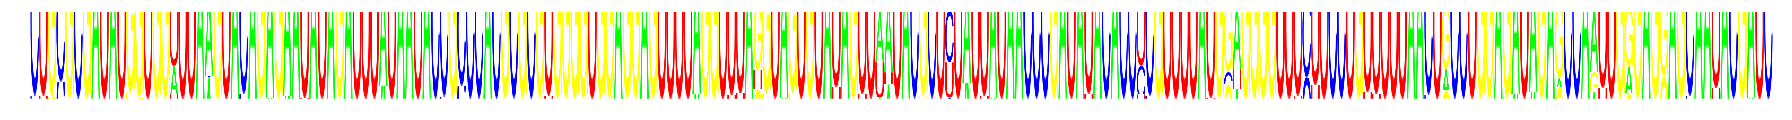

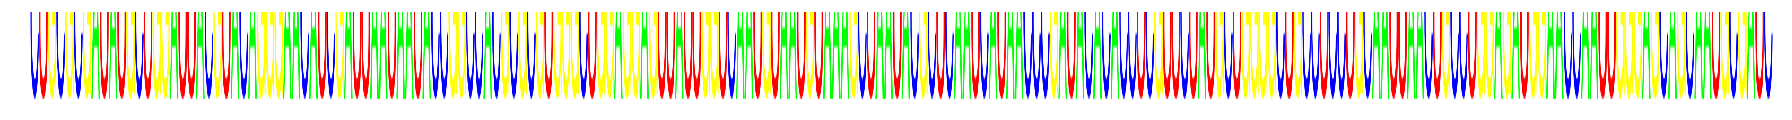

In [94]:
index = 4
pwm = np.squeeze(X2[index])
pwm2 = np.squeeze(X[index])

height=300
bp_width=30
num_seq = pwm.shape[1]
width = bp_width*num_seq
size = (25.,25.0)

#MAX = np.max(pwm,axis=0)
#maxX = np.exp(pwm-MAX)
maxX = np.exp(pwm)
sumX = np.sum(maxX,axis=0)
normX = maxX/np.outer(np.ones(4),sumX)

logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')

fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

logo = seq_logo(pwm2, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');


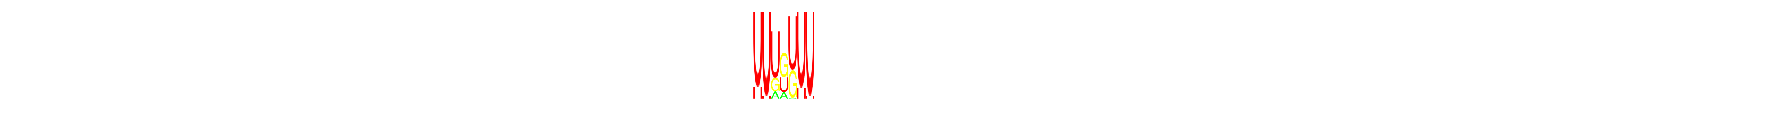

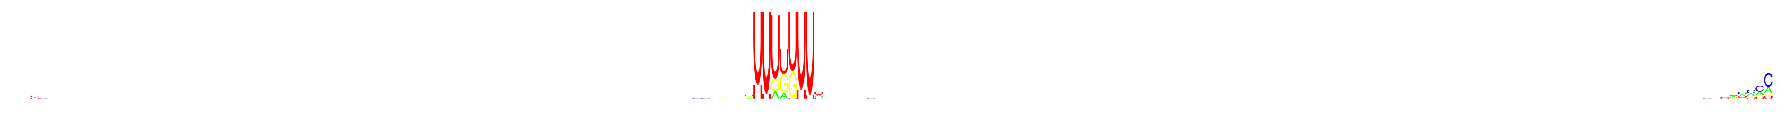

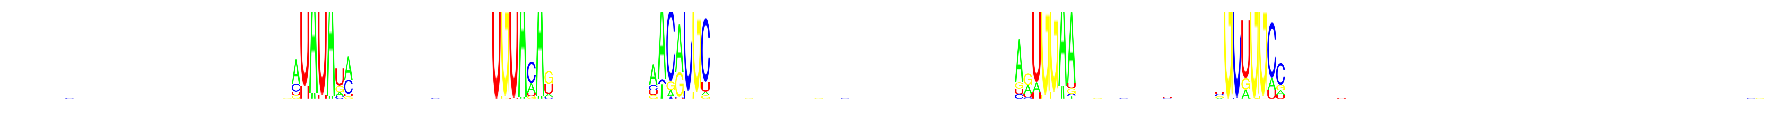

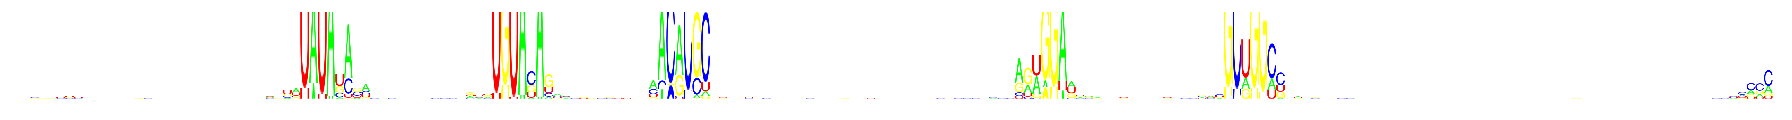

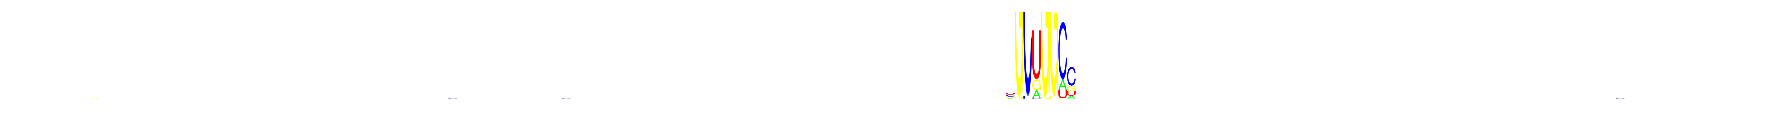

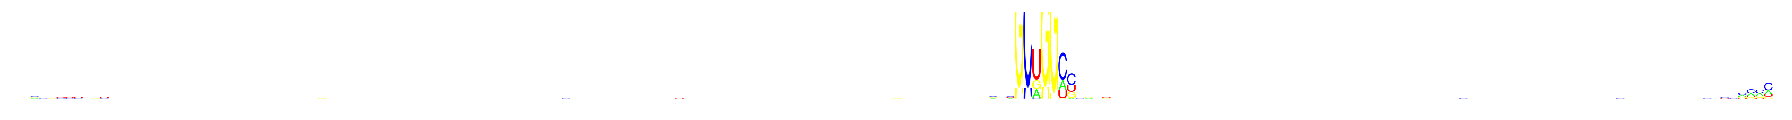

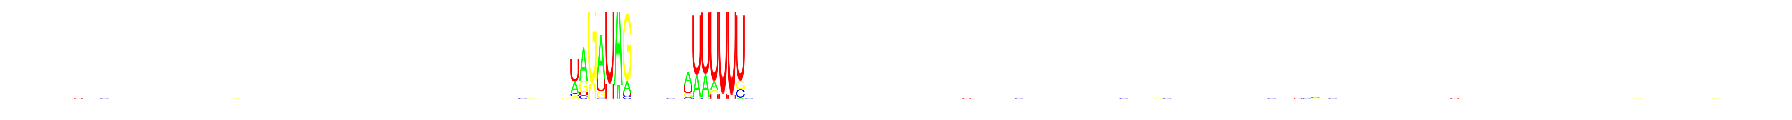

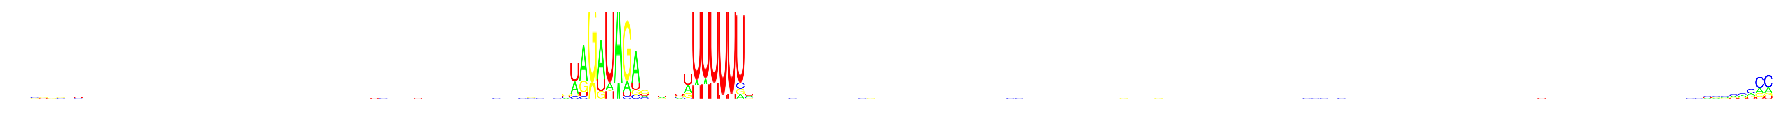

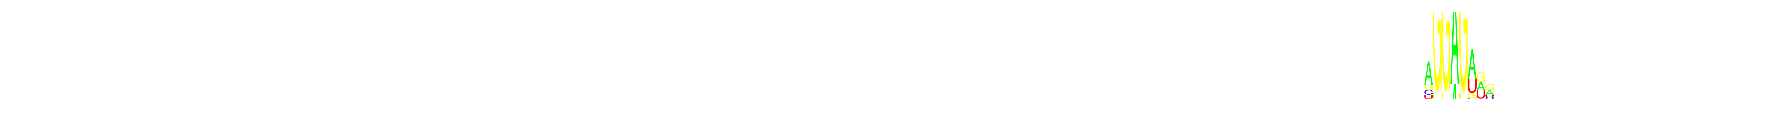

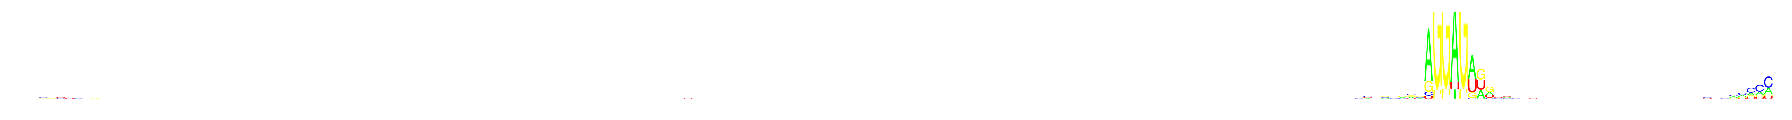

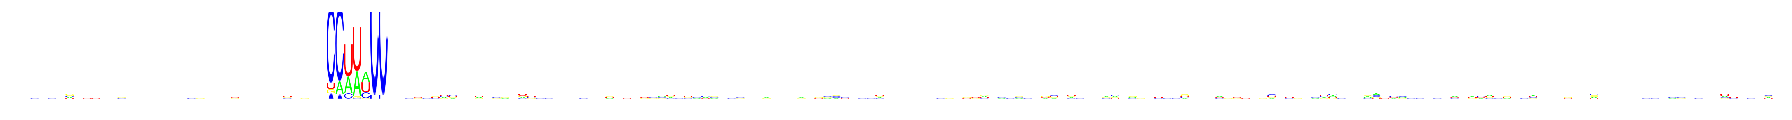

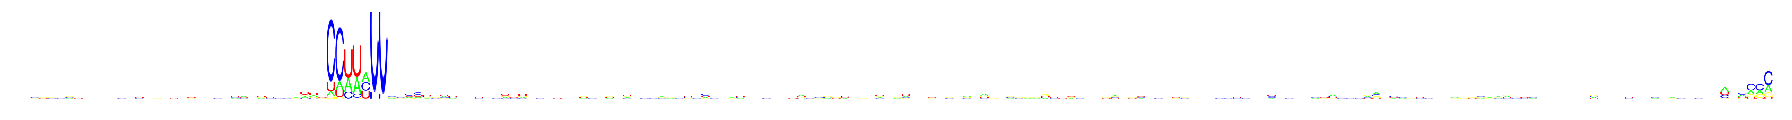

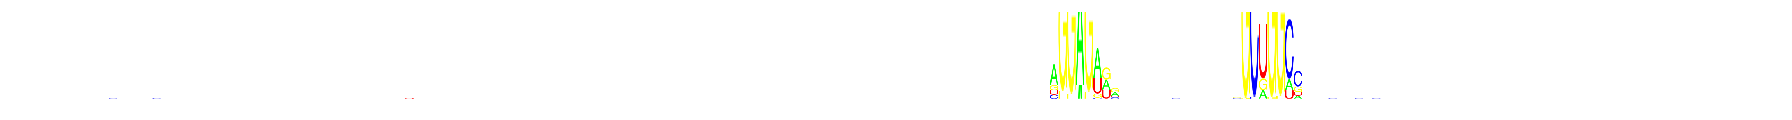

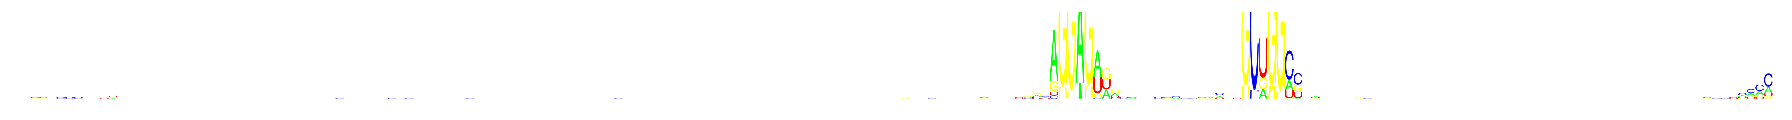

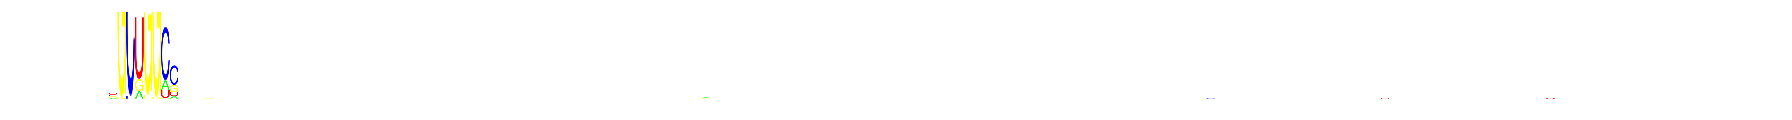

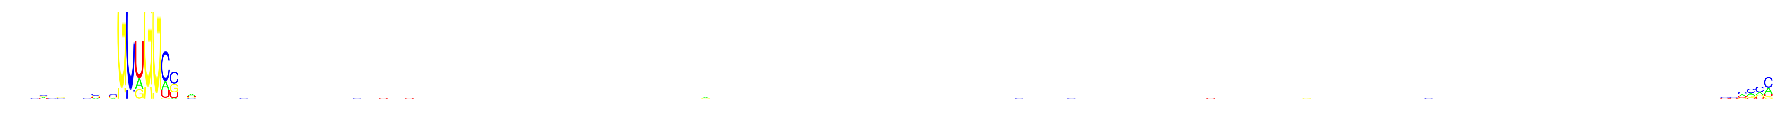

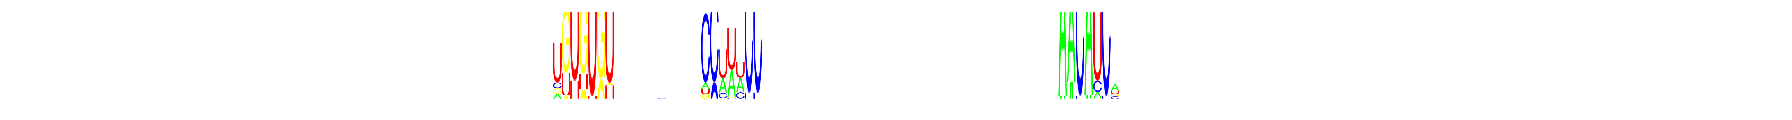

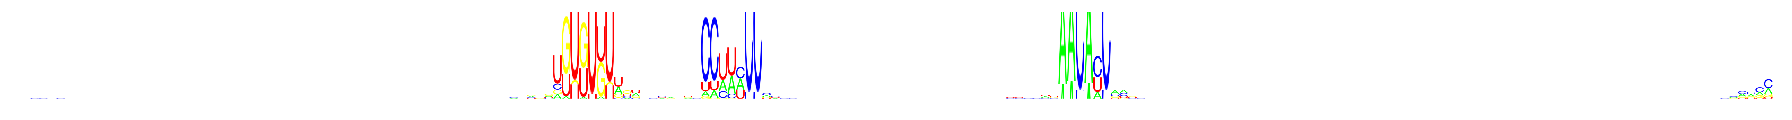

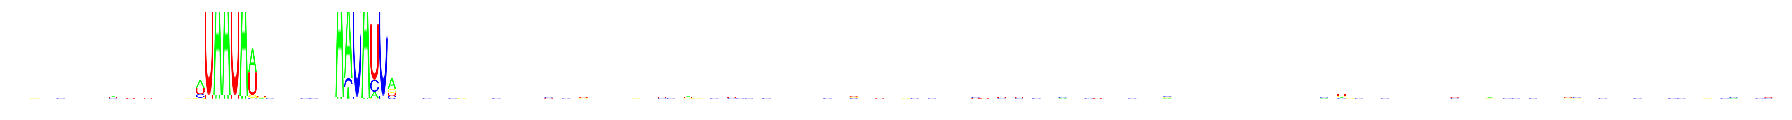

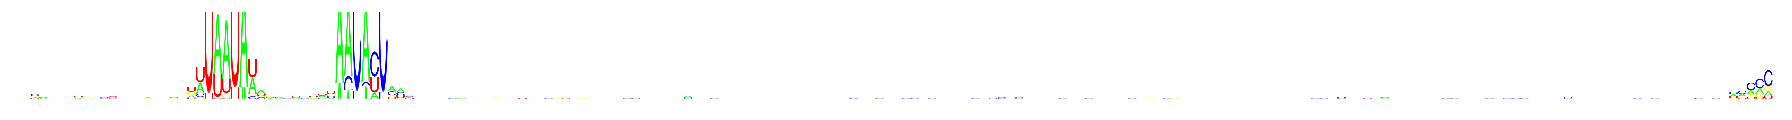

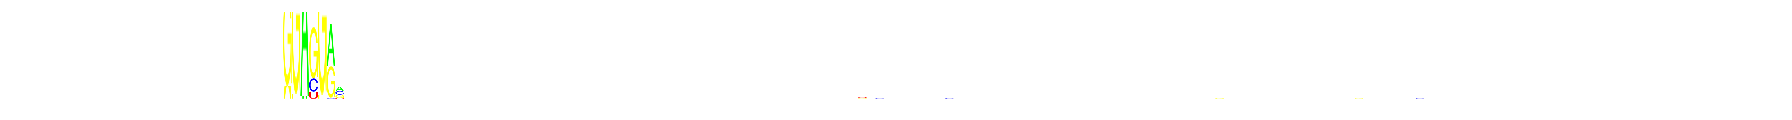

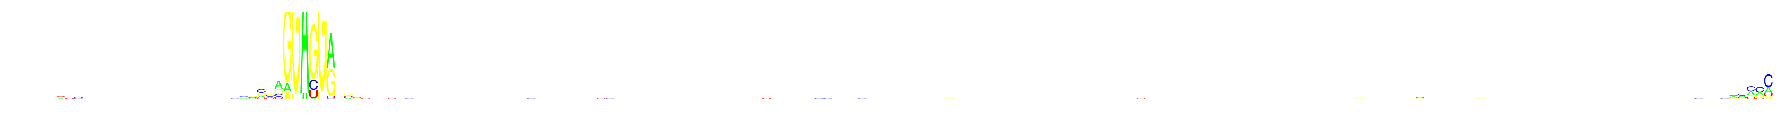

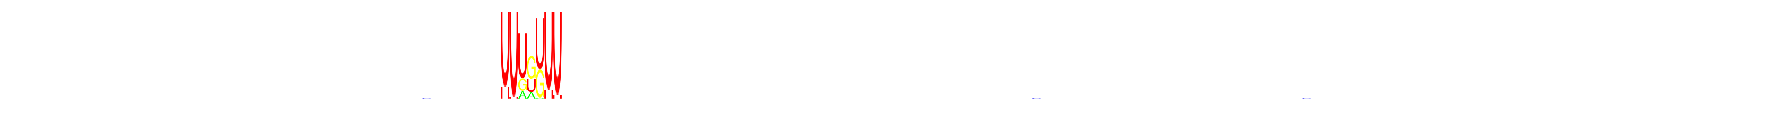

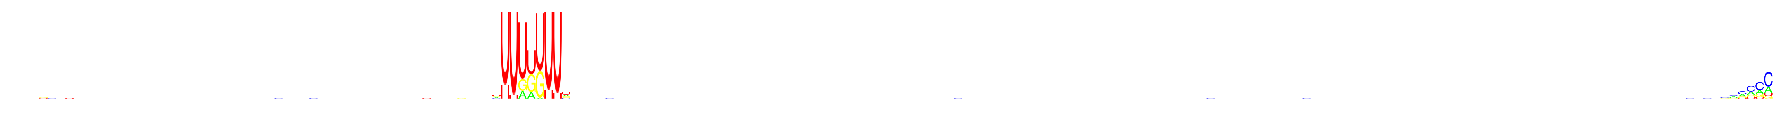

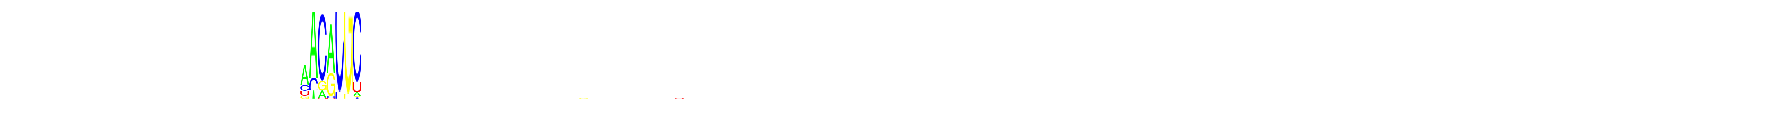

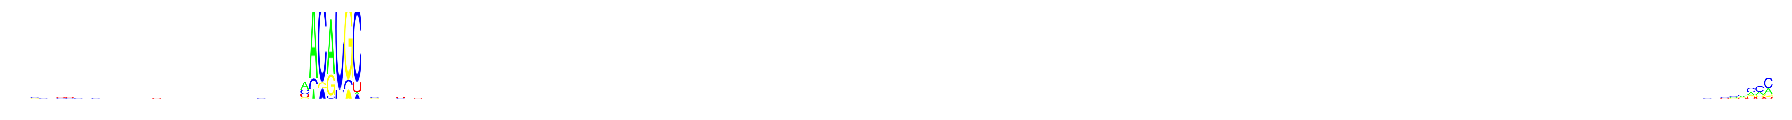

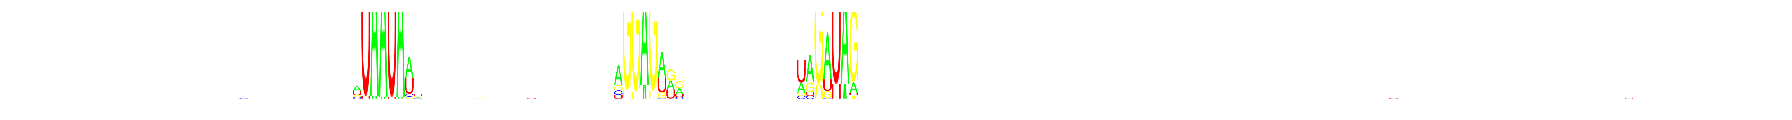

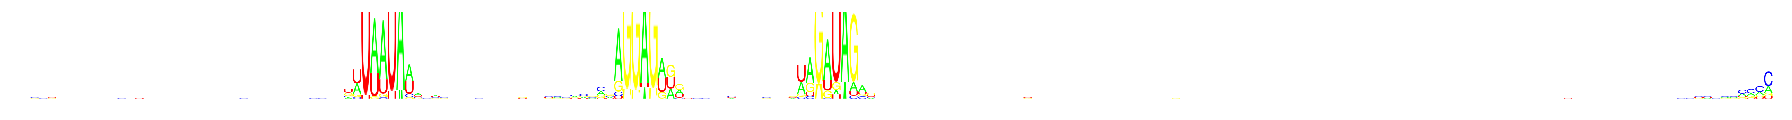

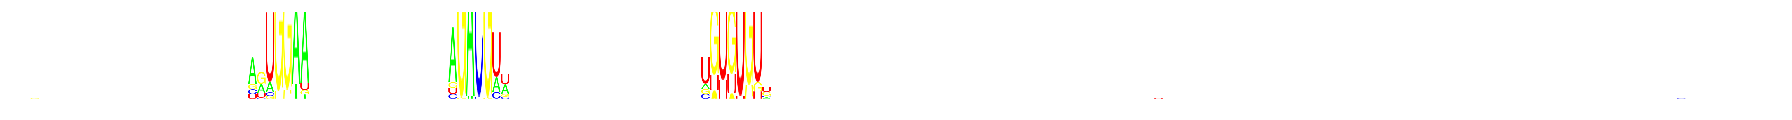

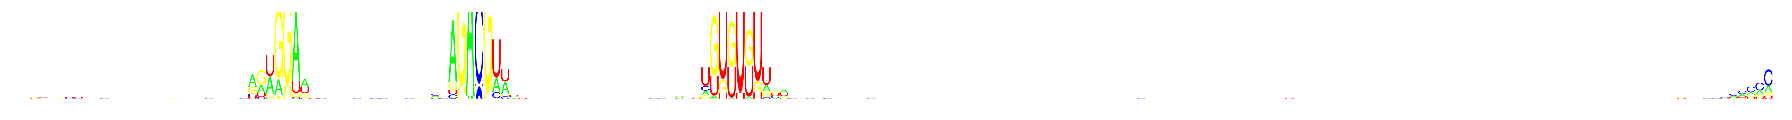

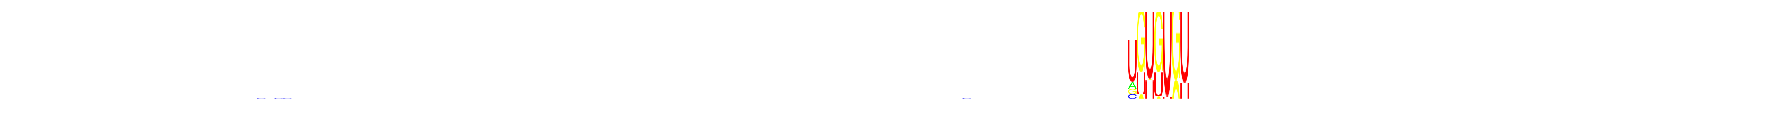

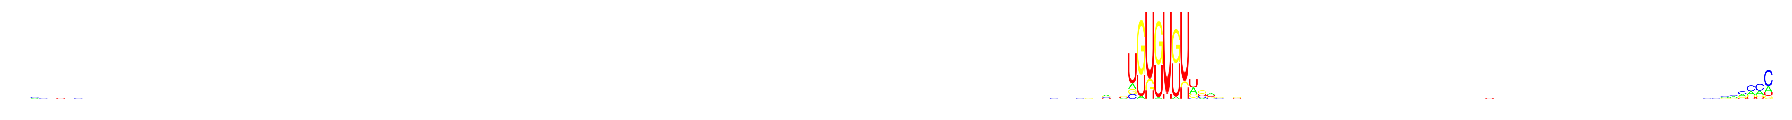

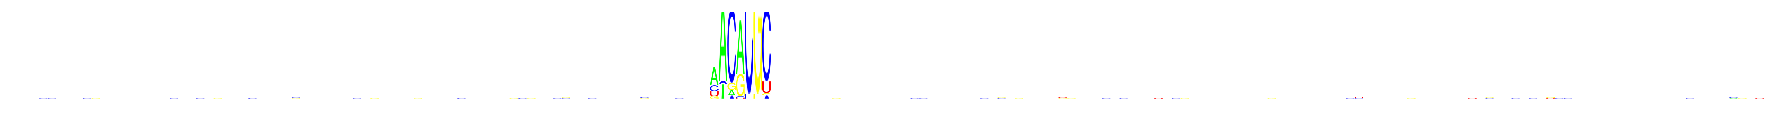

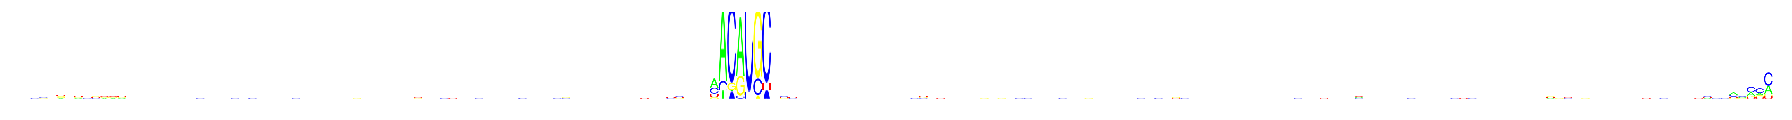

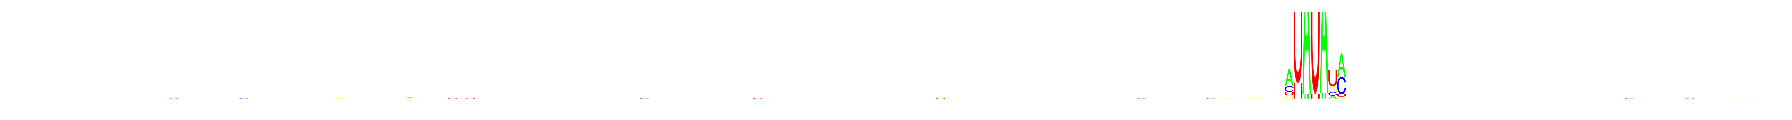

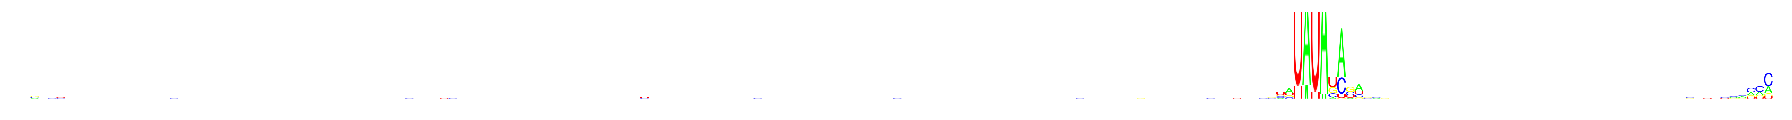

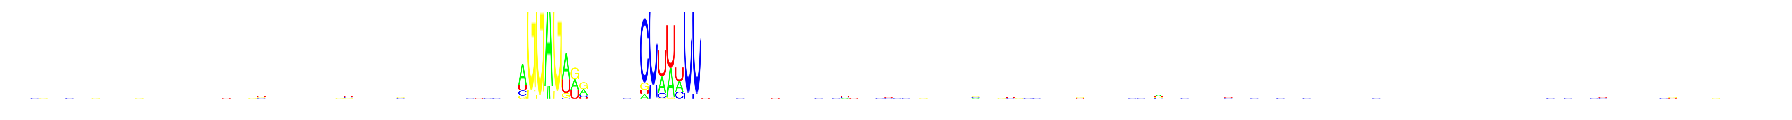

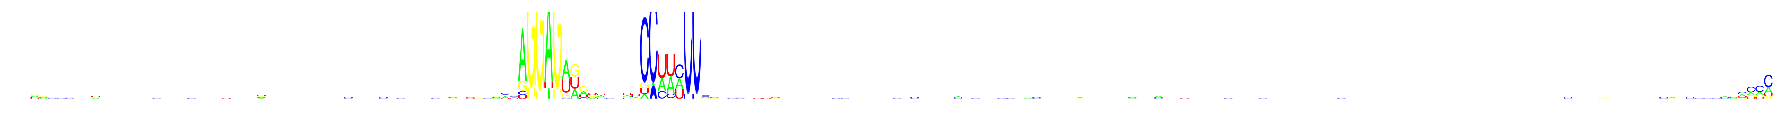

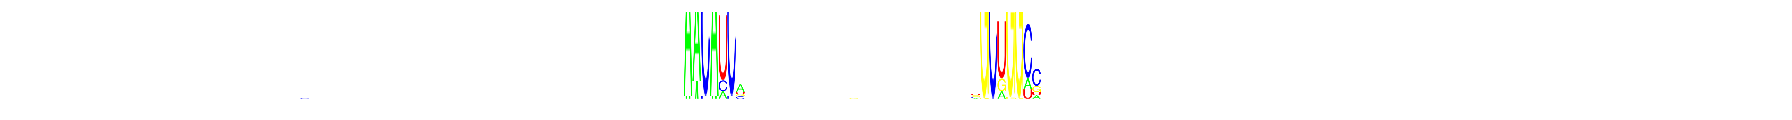

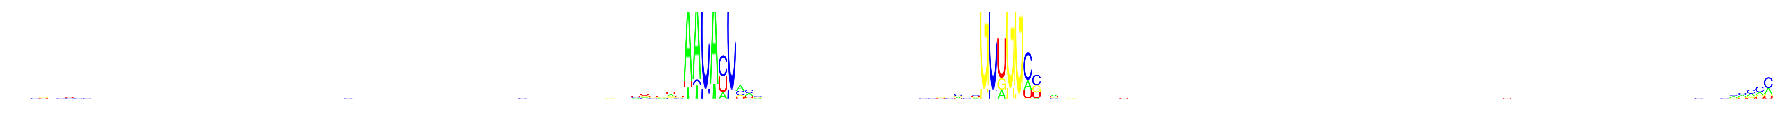

In [95]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            MEAN = np.nanmean(x,axis=1)
            x -= np.outer(MEAN, np.ones(x.shape[1]))
            #x -= np.max(x, axis=0)
            x = np.exp(x)
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm


for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    class_pwm = get_class_pwm(np.squeeze(X), class_index)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

    class_pwm = get_class_pwm(np.squeeze(X2), class_index, norm=1)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

Transpose

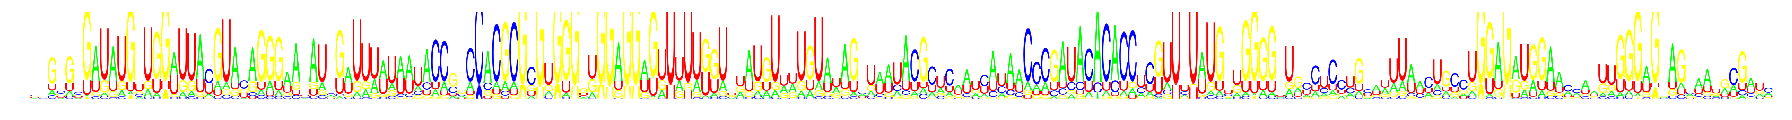

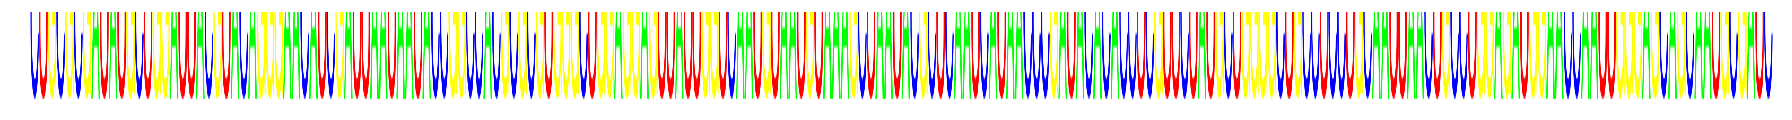

In [90]:
index = 4
pwm = np.squeeze(X2[index])
pwm2 = np.squeeze(X[index])

height=300
bp_width=30
num_seq = pwm.shape[1]
width = bp_width*num_seq
size = (25.,25.0)

#MAX = np.max(pwm,axis=0)
#maxX = np.exp(pwm-MAX)
maxX = np.exp(pwm)
sumX = np.sum(maxX,axis=0)
normX = maxX/np.outer(np.ones(4),sumX)

logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')

fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

logo = seq_logo(pwm2, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');


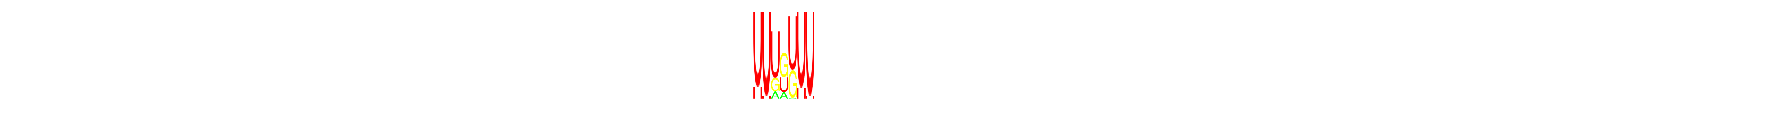

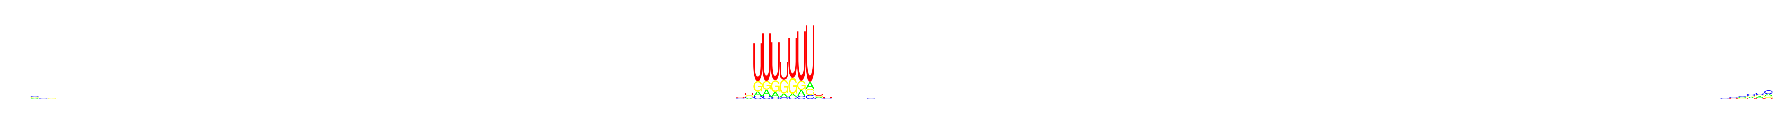

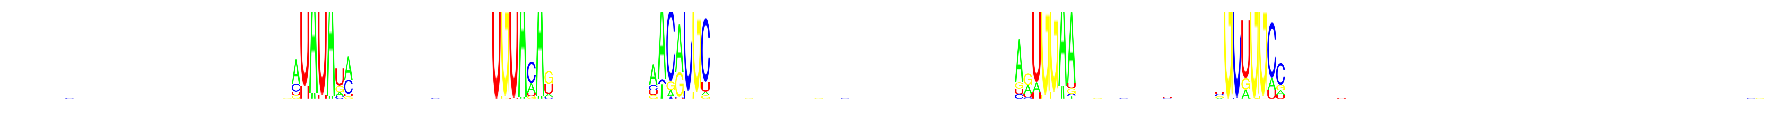

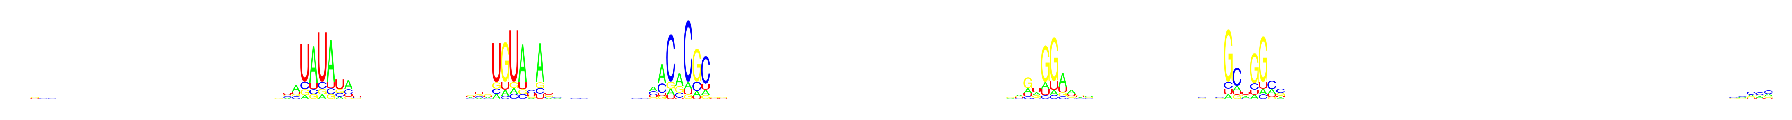

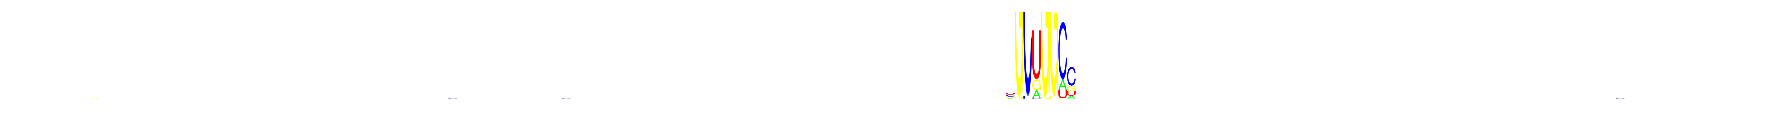

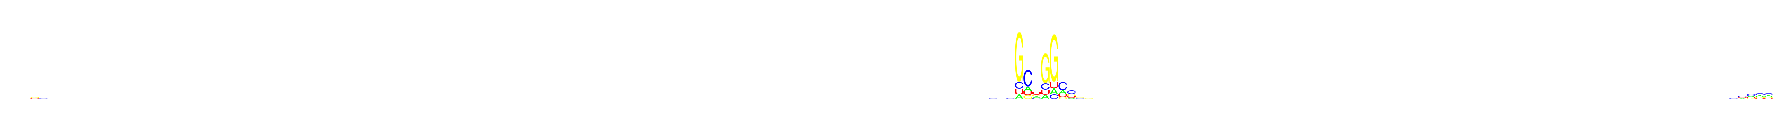

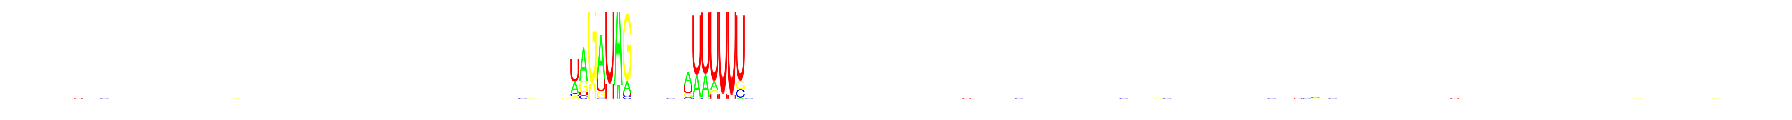

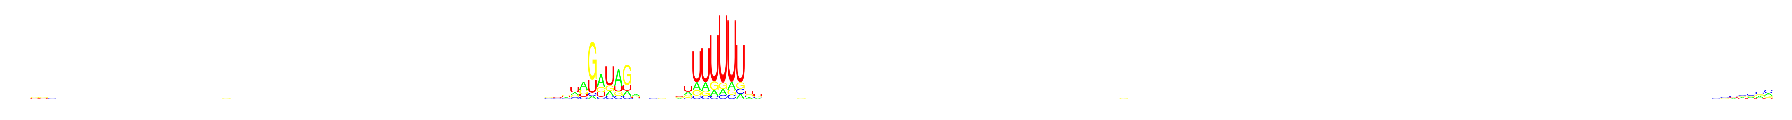

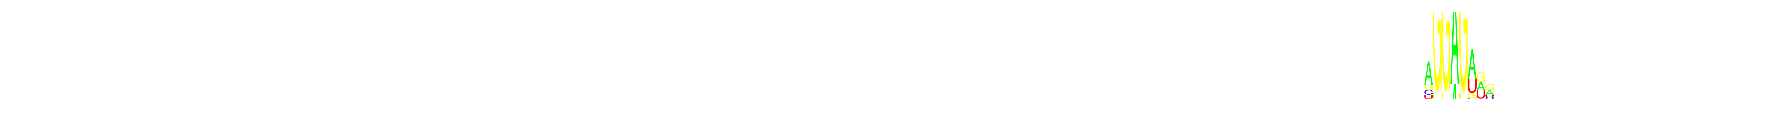

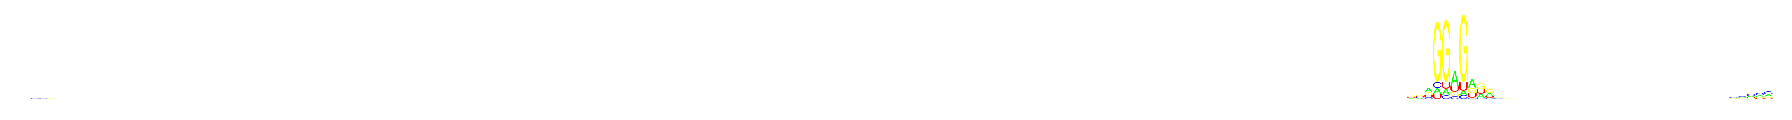

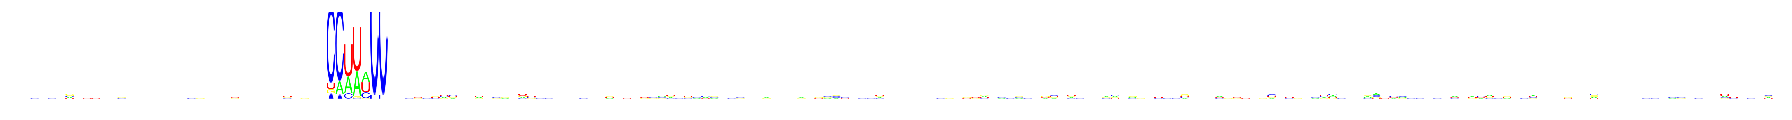

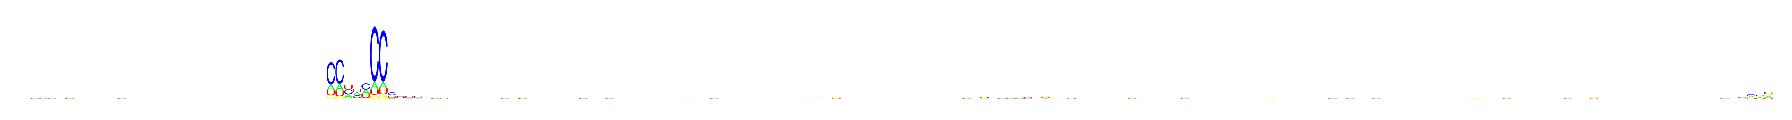

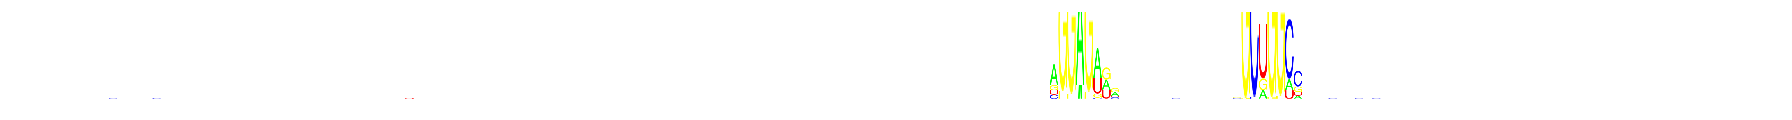

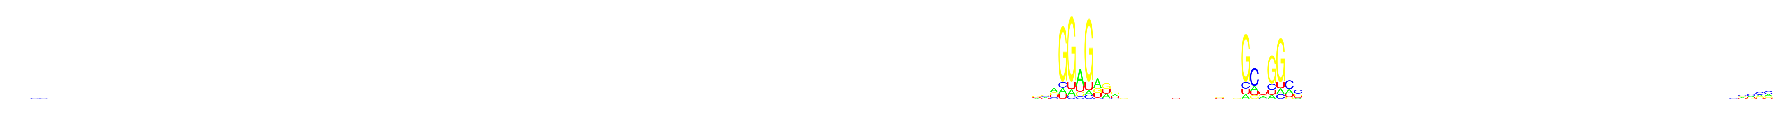

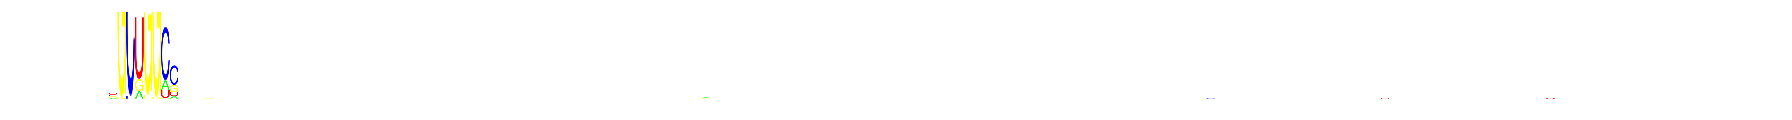

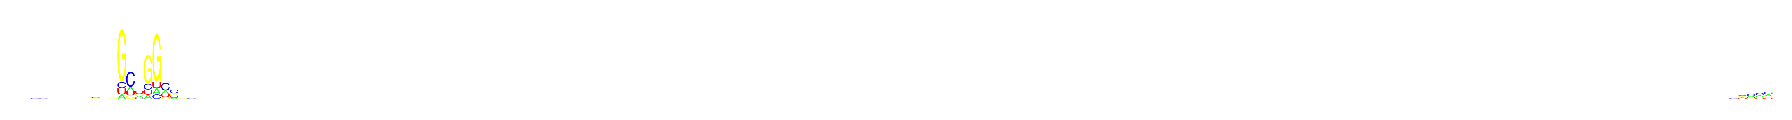

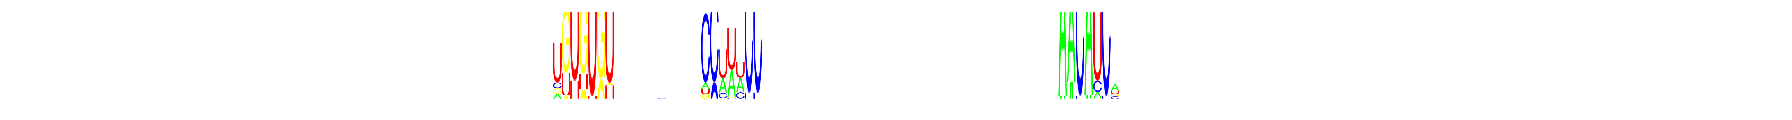

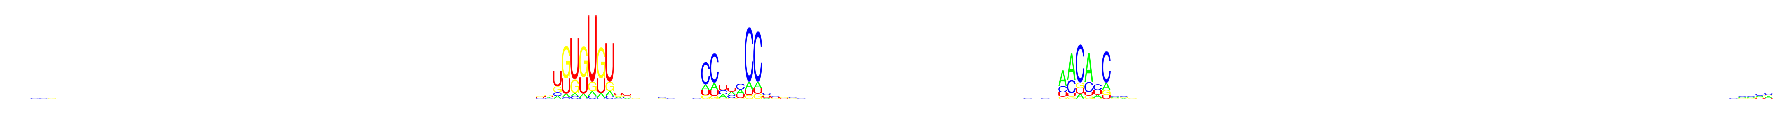

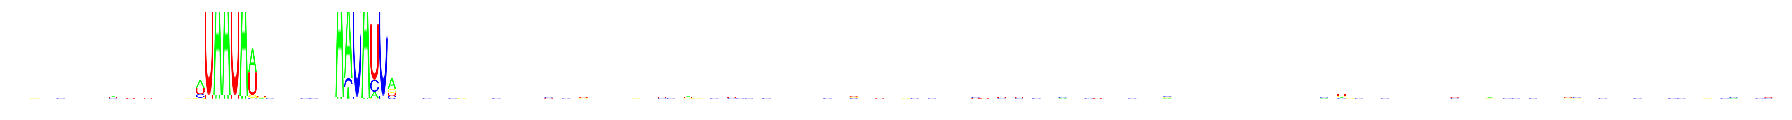

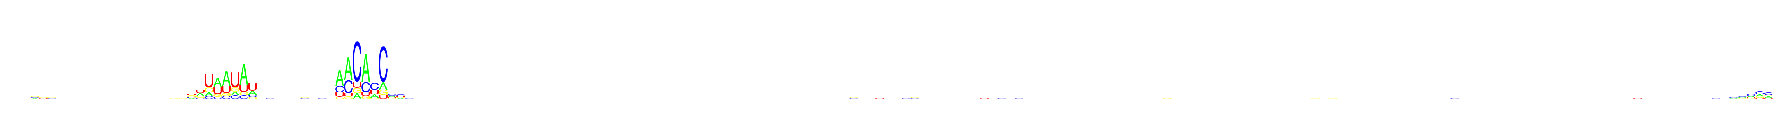

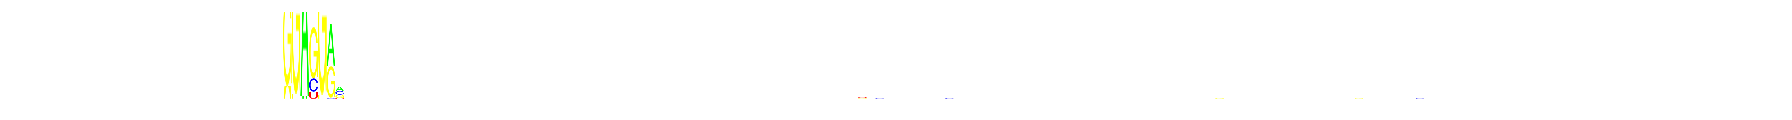

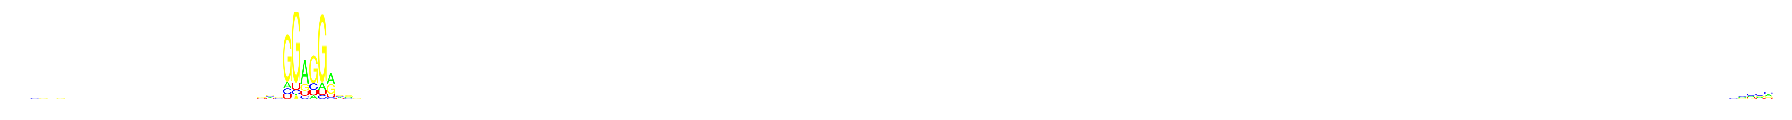

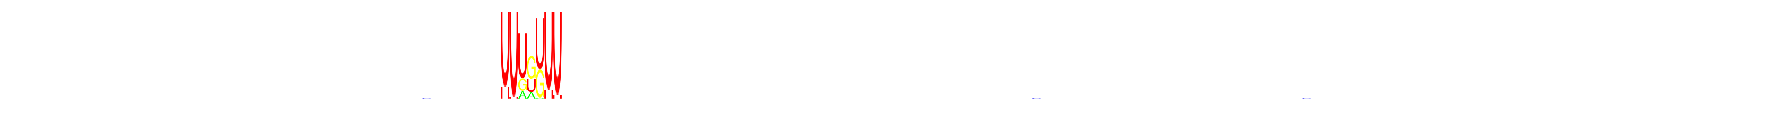

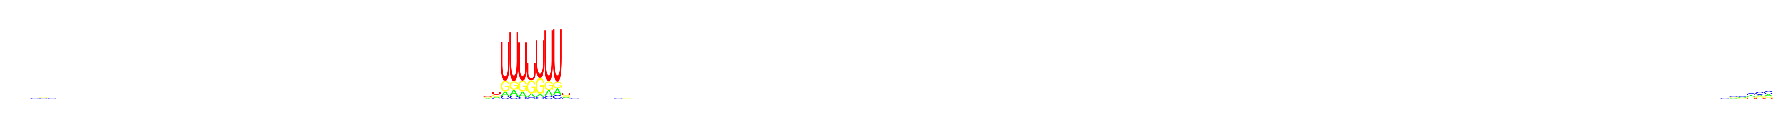

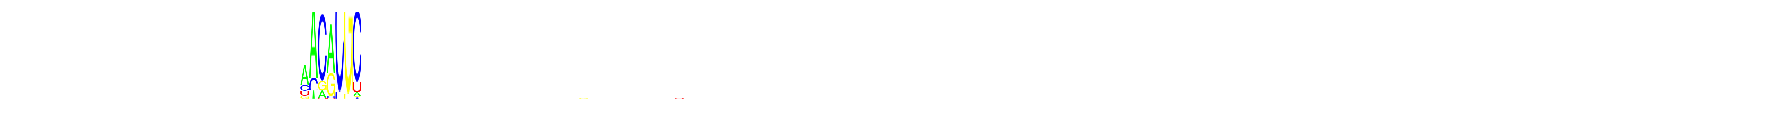

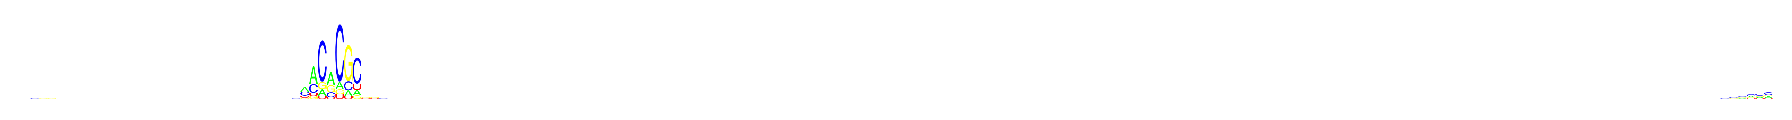

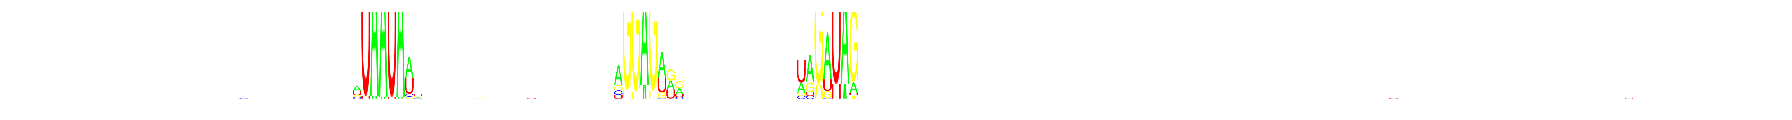

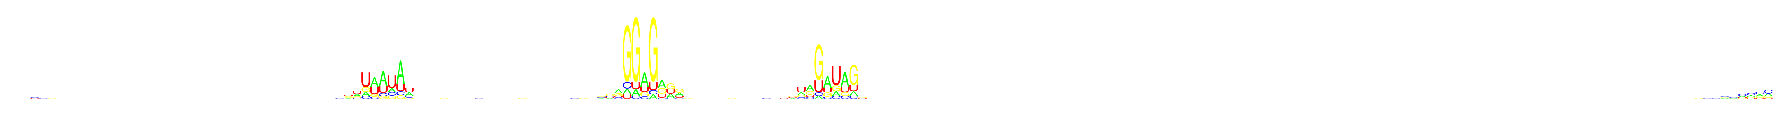

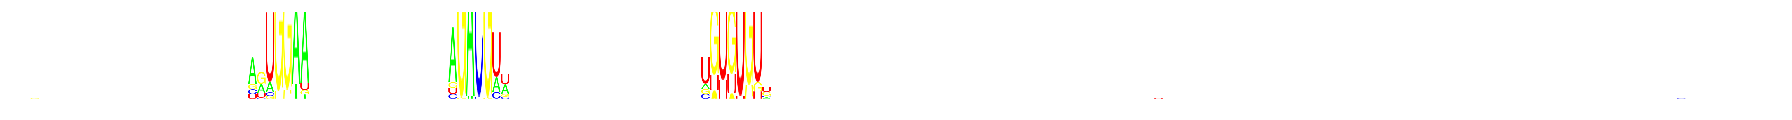

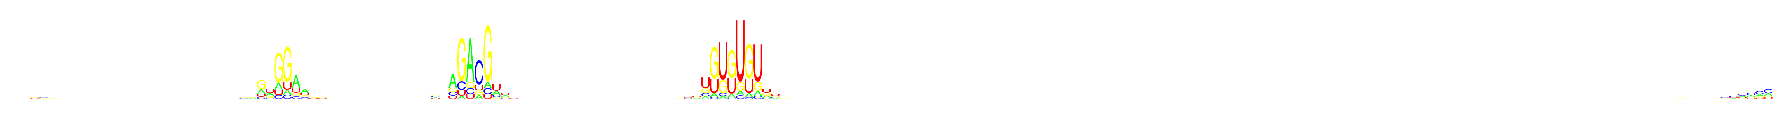

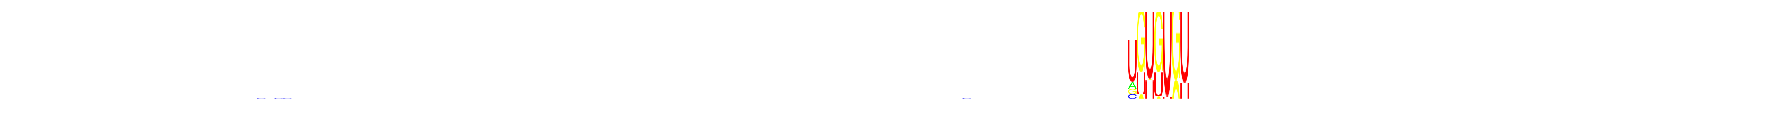

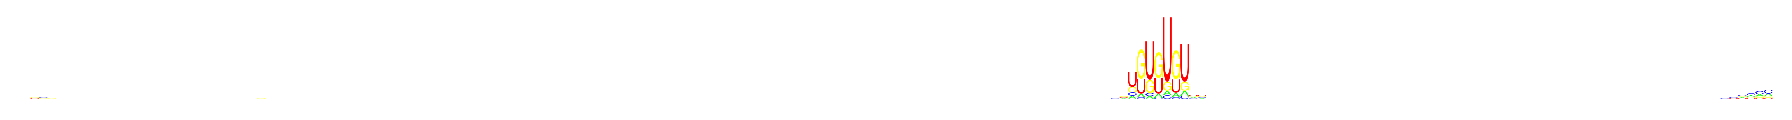

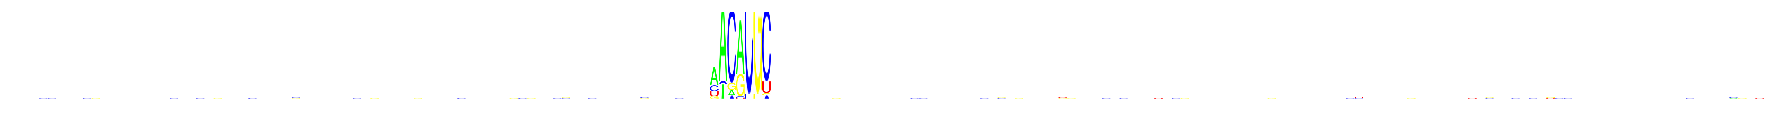

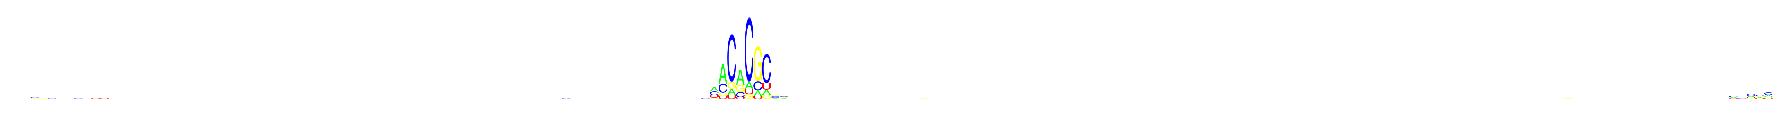

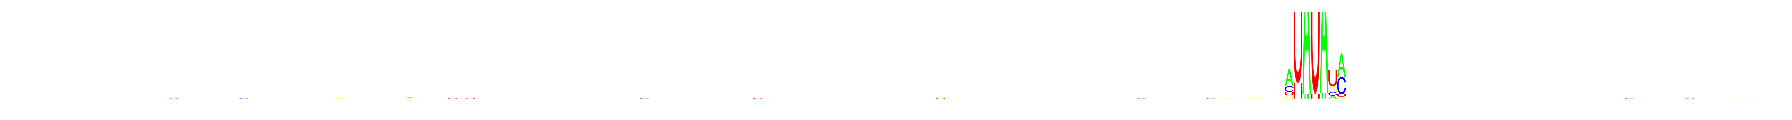

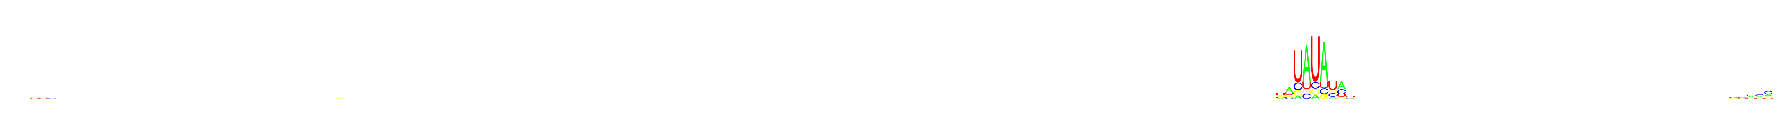

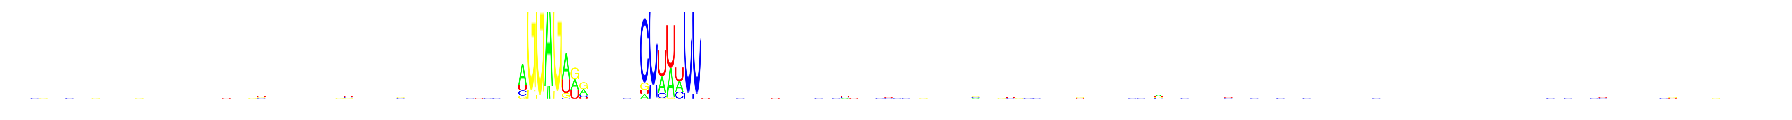

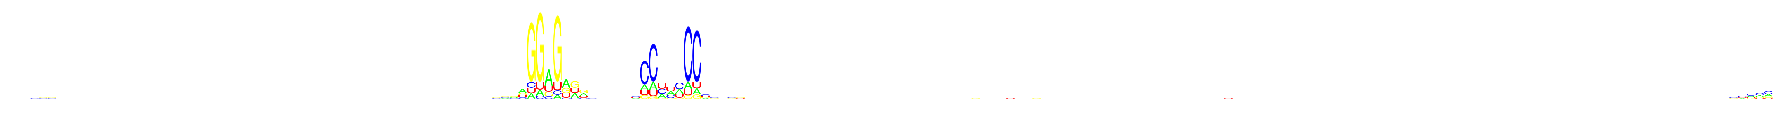

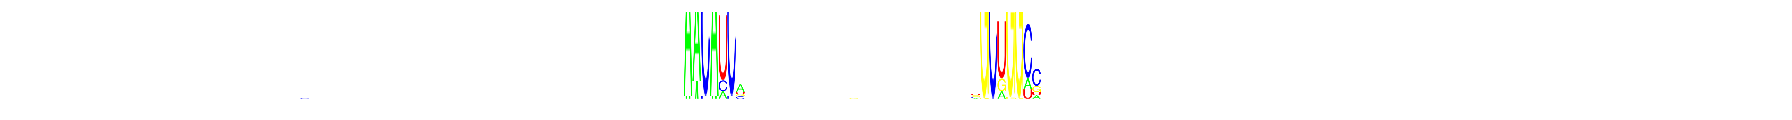

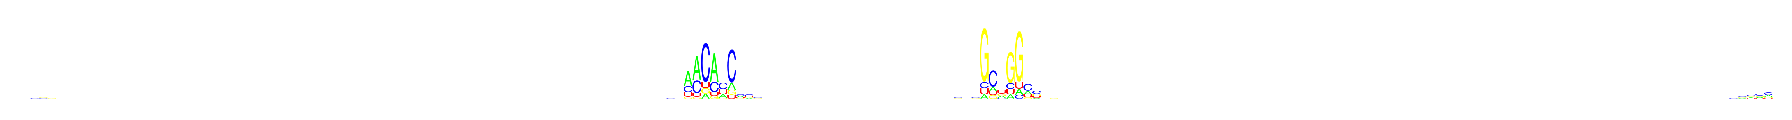

In [91]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            MEAN = np.nanmean(x,axis=1)
            x -= np.outer(MEAN, np.ones(x.shape[1]))
            #x -= np.max(x, axis=0)
            x = np.exp(x)
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm


for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    class_pwm = get_class_pwm(np.squeeze(X), class_index)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

    class_pwm = get_class_pwm(np.squeeze(X2), class_index, norm=1)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

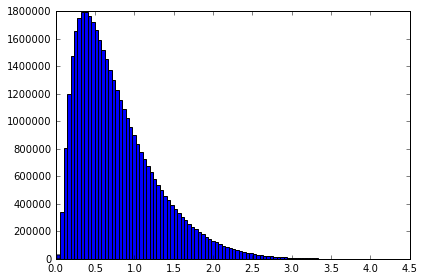

In [105]:
plt.figure()
plt.hist(a.reshape([-1,]), bins=100);